# Data

## Read

In [2]:
import pandas as pd
import numpy as np

df_train = pd.read_csv('../input/train.csv')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [3]:
df_test = pd.read_csv('../input/test.csv')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


In [42]:
X_train = df_train.values[:,1:]
X_train.shape

(42000, 784)

In [43]:
y_train = df_train.values[:,0]
y_train.shape

(42000,)

In [44]:
X_test = df_test.values
X_test.shape

(28000, 784)

## First look

In [19]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from jupyterthemes import jtplot
jtplot.style(theme='grade3')

Text(0.5,1,'This is 4')

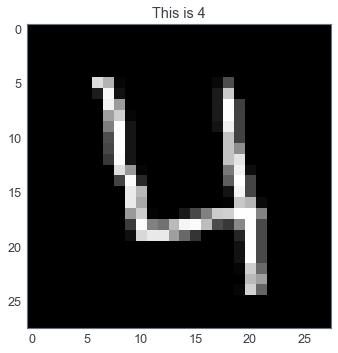

In [20]:
plt.imshow(X_train[3].reshape(28,28), cmap='gray')
plt.grid(False)
plt.title("This is {}".format(y_train[3]))

# Pre-processing

## Scaling

In [45]:
max_sig = np.max(X_train)
max_sig

255

In [46]:
X_train = X_train / max_sig
X_test = X_test / max_sig

## PCA

In [36]:
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
pca.fit(X_train)
pca_results = pca.explained_variance_ratio_

(1e-06, 1)

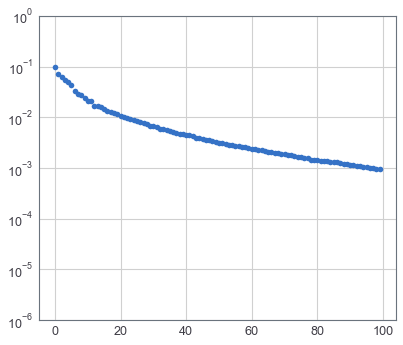

In [37]:
plt.semilogy(range(len(pca_results)), pca_results, 'bo')
plt.ylim([1e-6,1])

In [38]:
X_train = pca.transform(X_train)
X_train.shape

(42000, 100)

# Models

## DNN

In [50]:
import tensorflow as tf
from tensorflow import keras

dnn = keras.Sequential([
    keras.layers.Dense(units=300, activation='relu'),
    keras.layers.Dense(units=100, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [51]:
dnn.compile(optimizer=tf.keras.optimizers.Adam(),
           loss=tf.keras.losses.sparse_categorical_crossentropy,
           metrics=['accuracy'])

In [52]:
dnn_history = dnn.fit(X_train, y_train, epochs=50, validation_split=0.2)

Train on 33600 samples, validate on 8400 samples
Epoch 1/50
33600/33600 [==============================] - 4s 131us/step - loss: 0.2821 - acc: 0.9163 - val_loss: 0.1555 - val_acc: 0.9515
Epoch 2/50
33600/33600 [==============================] - 4s 116us/step - loss: 0.1191 - acc: 0.9639 - val_loss: 0.1153 - val_acc: 0.9644
Epoch 3/50
33600/33600 [==============================] - 4s 127us/step - loss: 0.0812 - acc: 0.9749 - val_loss: 0.0829 - val_acc: 0.9733
Epoch 4/50
33600/33600 [==============================] - 4s 111us/step - loss: 0.0582 - acc: 0.9811 - val_loss: 0.0879 - val_acc: 0.9750
Epoch 5/50
33600/33600 [==============================] - 4s 121us/step - loss: 0.0441 - acc: 0.9859 - val_loss: 0.0958 - val_acc: 0.9740
Epoch 6/50
33600/33600 [==============================] - 4s 122us/step - loss: 0.0368 - acc: 0.9888 - val_loss: 0.0871 - val_acc: 0.9760
Epoch 7/50
33600/33600 [==============================] - 4s 120us/step - loss: 0.0303 - acc: 0.9899 - val_loss: 0.1150 - v

In [14]:
acc = dnn_history.history['acc']
val_acc = dnn_history.history['val_acc']
epochs = range(1, len(acc)+1)

ValueError: x and y must have same first dimension, but have shapes (50,) and (1,)

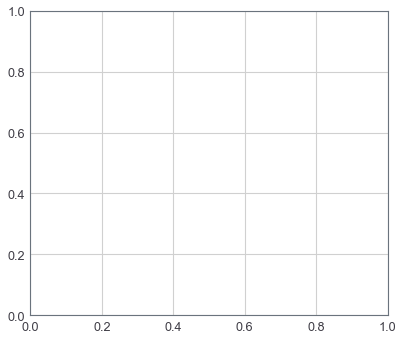

In [67]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('DNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.9,1])
plt.legend()

In [23]:
dnn.save('../save/dnn.h5')

In [25]:
new_dnn = keras.models.load_model('../save/dnn.h5')
new_dnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [27]:
loss, acc = dnn.evaluate(X_train, y_train)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

42000/42000 [==============================] - 1s 25us/step
Restored model, accuracy: 99.36%


In [26]:
loss, acc = new_dnn.evaluate(X_train, y_train)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

42000/42000 [==============================] - 1s 26us/step
Restored model, accuracy: 99.36%


## CNN

In [68]:
cnn = keras.Sequential([
    keras.layers.Conv2D(32, kernel_size=(5,5), strides=(1,1), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(64, kernel_size=(5,5), strides=(1,1), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1)),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(10, activation='softmax'),
])

In [69]:
cnn.compile(optimizer=tf.keras.optimizers.Adam(),
           loss=tf.keras.losses.sparse_categorical_crossentropy,
           metrics=['accuracy'])

In [70]:
cnn_history = cnn.fit(X_train.reshape(-1,28,28,1), y_train, epochs=50, validation_split=0.2)

Train on 33600 samples, validate on 8400 samples
Epoch 1/50
33600/33600 [==============================] - 28s 833us/step - loss: 0.1847 - acc: 0.9423 - val_loss: 0.0449 - val_acc: 0.9858
Epoch 2/50
33600/33600 [==============================] - 26s 776us/step - loss: 0.0626 - acc: 0.9807 - val_loss: 0.0369 - val_acc: 0.9889
Epoch 3/50
33600/33600 [==============================] - 30s 889us/step - loss: 0.0458 - acc: 0.9856 - val_loss: 0.0476 - val_acc: 0.9860
Epoch 4/50
33600/33600 [==============================] - 30s 893us/step - loss: 0.0376 - acc: 0.9887 - val_loss: 0.0349 - val_acc: 0.9905
Epoch 5/50
33600/33600 [==============================] - 33s 992us/step - loss: 0.0346 - acc: 0.9895 - val_loss: 0.0308 - val_acc: 0.9905
Epoch 6/50
33600/33600 [==============================] - 33s 989us/step - loss: 0.0286 - acc: 0.9913 - val_loss: 0.0371 - val_acc: 0.9899
Epoch 7/50
33600/33600 [==============================] - 34s 1ms/step - loss: 0.0276 - acc: 0.9914 - val_loss: 0.035

In [71]:
acc = cnn_history.history['acc']
val_acc = cnn_history.history['val_acc']
epochs = range(1, len(acc)+1)

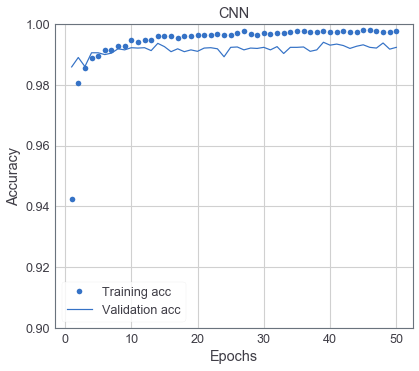

In [72]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.9,1])
plt.legend()

In [73]:
cnn.save('../save/cnn.h5')

# Error analysis

# Output

In [74]:
cnn.fit(X_train.reshape(-1,28,28,1), y_train, epochs=10)

Epoch 1/10
42000/42000 [==============================] - 33s 776us/step - loss: 0.0291 - acc: 0.9950
Epoch 2/10
42000/42000 [==============================] - 33s 796us/step - loss: 0.0219 - acc: 0.9956
Epoch 3/10
42000/42000 [==============================] - 34s 821us/step - loss: 0.0160 - acc: 0.9965
Epoch 4/10
42000/42000 [==============================] - 37s 889us/step - loss: 0.0150 - acc: 0.9971
Epoch 5/10
42000/42000 [==============================] - 39s 920us/step - loss: 0.0153 - acc: 0.9970
Epoch 6/10
42000/42000 [==============================] - 47s 1ms/step - loss: 0.0180 - acc: 0.9967
Epoch 7/10
42000/42000 [==============================] - 39s 938us/step - loss: 0.0149 - acc: 0.9969
Epoch 8/10
42000/42000 [==============================] - 39s 939us/step - loss: 0.0125 - acc: 0.9973
Epoch 9/10
42000/42000 [==============================] - 37s 877us/step - loss: 0.0140 - acc: 0.9971
Epoch 10/10
42000/42000 [==============================] - 39s 940us/step - loss: 0.

In [77]:
results = pd.Series(cnn.predict(X_test.reshape(-1,28,28,1)).argmax(axis=-1), name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"), results], axis = 1)
submission.to_csv("../save/predict_cnn.csv",index=False)